## Get the Weather Data from the Pedestrian Dataset

In [4]:
# Import the Dataset-----------------------------------

import pandas as pd
import numpy as np

url_cs = "https://data.stadt-zuerich.ch/dataset/hystreet_fussgaengerfrequenzen/download/hystreet_fussgaengerfrequenzen_seit2021.csv"

BHF = pd.read_csv(
    url_cs,
    sep=",",
    encoding="utf-8",
)

# Convert to DateTime-----------------------------------

BHF.timestamp = pd.to_datetime(BHF.timestamp, format="%Y-%m-%dT%XZ")


# Only keep Weather Data and create Dummies-----------------------------------

weather = BHF[["timestamp", "location_id", "weather_condition", "temperature"]]

weather = pd.get_dummies(weather, columns=["weather_condition"], drop_first=True)
weather.columns = weather.columns.str.replace("weather_condition_", "")

weather

,timestamp,location_id,temperature,clear-night,cloudy,fog,partly-cloudy-day,partly-cloudy-night,rain,snow,wind
0,2021-09-28 22:00:00,329,13.51,0,1,0,0,0,0,0,0
1,2021-09-28 22:00:00,331,13.51,0,1,0,0,0,0,0,0
2,2021-09-28 22:00:00,330,13.51,0,1,0,0,0,0,0,0
3,2021-09-28 23:00:00,329,13.46,0,1,0,0,0,0,0,0
4,2021-09-28 23:00:00,331,13.46,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
57061,2023-11-30 10:00:00,331,-0.10,0,0,0,0,0,0,1,0
57062,2023-11-30 10:00:00,330,-0.10,0,0,0,0,0,0,1,0
57063,2023-11-30 11:00:00,329,0.50,0,0,0,0,0,0,1,0
57064,2023-11-30 11:00:00,331,0.50,0,0,0,0,0,0,1,0


In [7]:
# Filter to End-Date-----------------------------------

weather = weather[["timestamp", "temperature", "clear-night", "cloudy", "fog", "partly-cloudy-day", "partly-cloudy-night", "rain", "snow", "wind"]]
weather = weather.groupby(by="timestamp").mean().reset_index()
end_date = "2023-11-08"
weather = weather.loc[weather["timestamp"] <= end_date]
weather.set_index("timestamp", inplace = True)
weather.rename_axis("Date", inplace = True)
weather


,temperature,clear-night,cloudy,fog,partly-cloudy-day,partly-cloudy-night,rain,snow,wind
Date,,,,,,,,,
2021-09-28 22:00:00,13.51,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-28 23:00:00,13.46,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-29 00:00:00,13.26,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2021-09-29 01:00:00,13.51,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2021-09-29 02:00:00,13.44,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2023-11-07 20:00:00,7.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2023-11-07 21:00:00,5.70,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2023-11-07 22:00:00,5.40,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


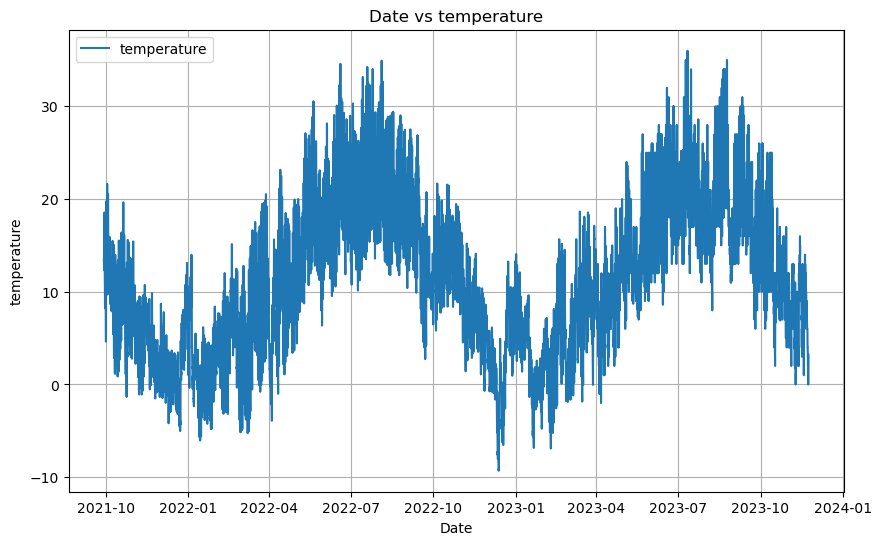

In [5]:
import matplotlib.pyplot as plt


# Plotting-----------------------------------

plt.figure(figsize=(10, 6))
plt.plot(weather.index, weather["temperature"], label = "temperature")

# Formatting-----------------------------------

plt.title("Date vs temperature")
plt.xlabel("Date")
plt.ylabel("temperature")
plt.legend()
plt.grid(True)
plt.show()


## Deseasoning and Scaling


In [9]:
# Import all the libraries-----------------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import statsmodels.api as st

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from statsmodels.tsa.seasonal import seasonal_decompose


plt.style.use("seaborn-v0_8-muted")

In [7]:
# Helpful functions for showing results of analysis-----------------------------------

# Show summary statistics for different time frames-----------------------------------

def split_series(series):
    X = series.values
    split1, split2 = round(len(X) / 3), round(len(X) / 3)*2
    X1, X2, X3 = X[0:split1], X[split1:split2], X[split2:]
    mean1, mean2, mean3 = X1.mean(), X2.mean(), X3.mean()
    std1, std2, std3 = X1.std(), X2.std(), X3.std()
    print(f"The means are{mean1: 0.2f},{mean2: 0.2f} and{mean3: 0.2f}")
    print(f"The stds are{std1: 0.2f},{std2: 0.2f} and{std3: 0.2f}")

# Run KPSS test (Null hypothesis: x is level or trend stationary)-----------------------------------

def kpss_test(series):
    print("Results of KPSS Test:")
    kpsstest = kpss(series, regression="ct", nlags="auto")
    print(f"Test Statistic {kpsstest[0]:0.3f}")
    print(f"p-value: {kpsstest[1]: 0.4f}")
    print(f"Lags used: {kpsstest[2]: 0.0f}")


# Run a Augmented Dickey-Fuller test (Null hypothesis: time series contains a unit root and is non-stationary)-----------------------------------

def run_test(series):
    result=adfuller (series, autolag="AIC", regression = "ctt")
    print(f"Results of the AD Fuller test:")
    print(f"Test Statistic: {result[0]: 0.3f}")
    print(f"p-value: {result[1]: 0.4f}")
    
# Plot results-----------------------------------

def plot_three(series, title, window_size = 24*7):
    figs = plt.figure(figsize=(10, 6))
    fig, axs = plt.subplots(2,1, figsize=(10,6))
    
    # Set a title-----------------------------------
    
    figs.suptitle(title, fontweight = "bold", fontsize = 16)
    
    gs = figs.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
    
    # Create the Axes for subplots-----------------------------------
    
    ax = figs.add_subplot(gs[1, 0])
    ax.tick_params(axis='x', which='major')
    ax_histx = figs.add_subplot(gs[0, 0], )
    ax_histy = figs.add_subplot(gs[1, 1])

    
    # Format x axis-----------------------------------
    
    date_form = DateFormatter("%b-%Y")
    ax.xaxis.set_major_formatter(date_form)
    
    # Populate the Axes-----------------------------------
    
    ax.plot(series, alpha = 0.8)
    ax.set_xlabel("Passengers")
    ax_histx.hist(series, alpha=0.5, edgecolor = "black", color = "pink")
    
    # Add moving average-----------------------------------
    
    rolling = series.rolling(window=window_size).mean()
    ax_histy.hist(rolling, alpha=0.5, orientation="horizontal", edgecolor = "black", color = "pink")
    ax_histy.set_yticklabels([])
    ax_histx.set_xticklabels([])
    ax_histx.set_title("Distribution of Sunshine")
    ax_histy.set_title(f'Rolling means', rotation=0)
    
    # Plot series and Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)-----------------------------------
    
    st.graphics.tsa.plot_pacf(series, ax = axs[0], lags = 24)
    st.graphics.tsa.plot_acf(series, axs[1], lags = 24)
    plt.tight_layout()
    
    # Run the tests-----------------------------------
    
    run_test(series)
    print("----------------")
    kpss_test(series)
    print("----------------")
    split_series(series)

In [8]:
weather.reset_index(inplace = True)
transform = weather[["Date", "temperature"]]
transform.set_index("Date", inplace = True)

,temperature
Date,
2021-09-28 22:00:00,13.51
2021-09-28 23:00:00,13.46
2021-09-29 00:00:00,13.26
2021-09-29 01:00:00,13.51
2021-09-29 02:00:00,13.44
...,...
2023-11-23 06:00:00,0.00
2023-11-23 07:00:00,1.00
2023-11-23 08:00:00,2.00


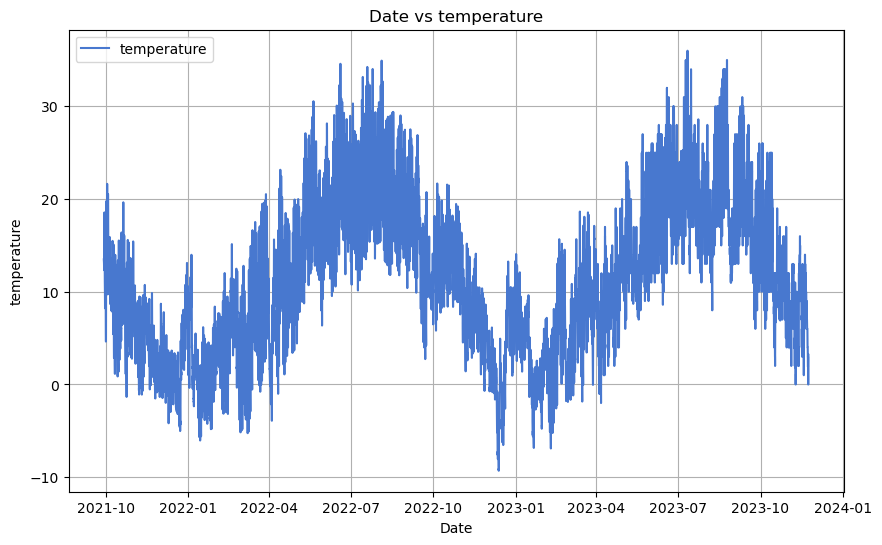

In [9]:
import matplotlib.pyplot as plt

# Plotting-----------------------------------

plt.figure(figsize=(10, 6))
plt.plot(transform.index, transform["temperature"], label = "temperature")

# Formatting-----------------------------------

plt.title('Date vs temperature')
plt.xlabel('Date')
plt.ylabel('temperature')
plt.legend()
plt.grid(True)
plt.show()


Results of the AD Fuller test:
Test Statistic: -24.220
p-value:  0.0000
----------------
Results of KPSS Test:
Test Statistic 0.028
p-value:  0.1000
Lags used:  71
----------------
The means are 0.03,-0.07 and-0.00
The stds are 2.67, 2.60 and 3.14


/var/folders/bp/ly_w1kqj7gs4yy61jdj69bqr0000gn/T/ipykernel_26927/2081436272.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(series, regression="ct", nlags="auto")


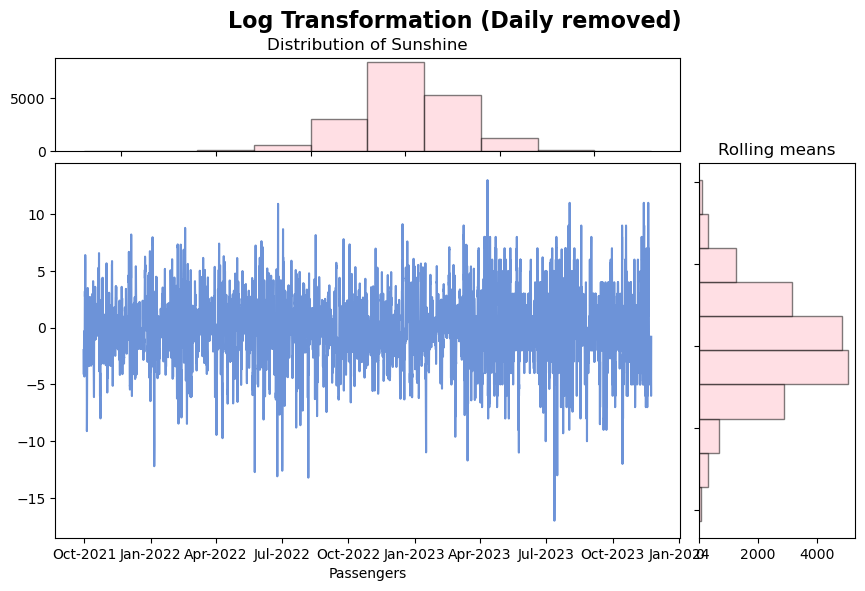

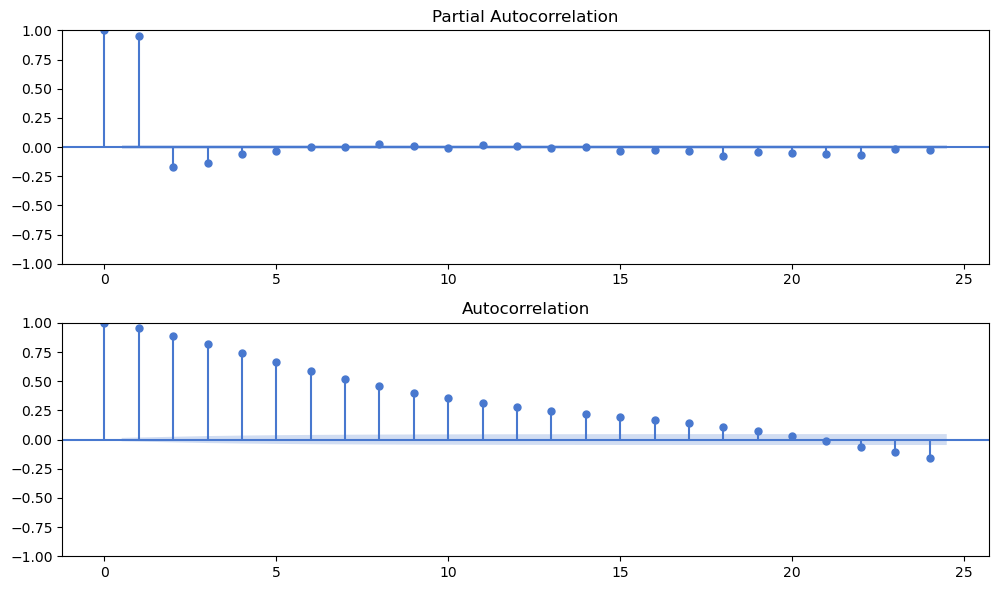

In [10]:
# Eliminate daily seasonality-----------------------------------

daily_24 = transform.diff(24).dropna()
plot_three(daily_24.temperature, "Log Transformation (Daily removed)")

In [11]:
# Apply MinMax Scaler-----------------------------------

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
daily_24["temperature"] = scaler.fit_transform(daily_24["temperature"].values.reshape(-1, 1))
display(daily_24)

,temperature
Date,
2021-09-29 22:00:00,0.501000
2021-09-29 23:00:00,0.487667
2021-09-30 00:00:00,0.487333
2021-09-30 01:00:00,0.466667
2021-09-30 02:00:00,0.452000
...,...
2023-11-23 06:00:00,0.366667
2023-11-23 07:00:00,0.400000
2023-11-23 08:00:00,0.466667


In [13]:
daily_24.to_csv("temperature_scaled.csv")

In [53]:
weather.to_csv("weather_scaled.csv", index = False)